In [7]:
from Bio import Phylo, AlignIO, Phylo
from io import StringIO
from Bio.Phylo.TreeConstruction import ParsimonyScorer, NNITreeSearcher, ParsimonyTreeConstructor
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

## Ejercicio 3.1: UPGMA a mano a partir del FASTA

Para poder realizar el ejercicio, cabe destacar que UPGMA necesita que las secuencias estén alineadas para poder contar diferencias posición a posición. En el FASTA que se nos ha proporcionado, ya aparecen con guiones, por lo que se interpreta que el alineamiento ya está hecho.

Sin embargo, _Homo Sapiens_ aparece con 22 caracteres, y el resto de secuencias tiene 23. Para poder hacer bien la comparación, asumimos que a _Homo Sapiens_ le falta el último carácter y añadimos un guion al final para igualar longitudes (ATGCTAGCTAGCTACG--TACG-).

Ahora, contamos diferencias (Hamming): misma letra = 0, letra distinta = +1, y tratamos el guion como un carácter más (gap vs nucleótido cuenta como diferencia; gap vs gap no cuenta).

### Paso 1. Matriz de distancias (tabla de diferencias)

Para abreviar, las llamamos de la siguiente manera:
- H = Homo_sapiens
- P = Pan_troglodytes
- G = Gorilla_gorilla
- O = Pongo_abelii
- M = Macaca_mulatta

Contando diferencias posición a posición, salen:
- d(H,P)=1
- d(H,G)=2
- d(H,O)=5
- d(H,M)=8
- d(P,G)=1
- d(P,O)=4
- d(P,M)=7
- d(G,O)=3
- d(G,M)=6
- d(O,M)=4

La matriz simétrica queda de la siguiente forma:

|        | C1=(H,P) | G   | O   | M   |
| ------ | -------- | --- | --- | --- |
| **C1** | 0        | 1.5 | 4.5 | 7.5 |
| **G**  | 1.5      | 0   | 3   | 6   |
| **O**  | 4.5      | 3   | 0   | 4   |
| **M**  | 7.5      | 6   | 4   | 0   |

### Paso 2. Buscar la distancia mínima y agrupar

La distancia mínima es 1, y aparece en dos pares:
- (H, P) 
- (P, G) 

Aquí hay empate, y UPGMA permite elegir cualquiera. En este caso, se ha elegido (H,P) por su sentido biológico (humano y chimpancé muy cercanos).

 Por lo tanto, el primer cluster es: 
 - C1 = (H,P) con distancia 1.

En UPGMA, la altura del nodo (tiempo/distancia ultramétrica) es:

$$
h(C1) = \frac{d(H, P)}{2} = \frac{1}{2} = 0.5
$$

### Paso 3. Recalcular distancias por promedio (UPGMA)

La distancia entre un cluster y otra secuencia se calcula como promedio aritmético de las distancias de sus miembros. Las distancias desde C1=(H,P) al resto son:

- d(C1, G) = (d(H,G)+d(P,G))/2 = (2+1)/2 = 1.5
- d(C1, O) = (5+4)/2 = 4.5
- d(C1, M) = (8+7)/2 = 7.5

Por lo tanto, la nueva tabla es:

|        | C1=(H,P) | G   | O   | M   |
| ------ | -------- | --- | --- | --- |
| **C1** | 0        | 1.5 | 4.5 | 7.5 |
| **G**  | 1.5      | 0   | 3   | 6   |
| **O**  | 4.5      | 3   | 0   | 4   |
| **M**  | 7.5      | 6   | 4   | 0   |

Ahora, la mínima es 1.5, así que se agrupa:

*Segundo cluster:* C2 = (G, C1) = (G,(H,P)) con distancia 1.5. 

La altura es:

$$
h(C2) = \frac{1.5}{2} = 0.75
$$

### Paso 4. Recalcular de nuevo

Ahora, se tienen tres "unidades": C2, O, M.

Las distancias son:
- d(C2, O) = promedio entre (G,O), (H,O), (P,O)
$$
d(C2, O) = \frac{3 + 5 + 4}{3} = 4.0
$$
- d(C2, M) = promedio entre (G,M), (H,M), (P,M)
$$
d(C2, M) = \frac{6 + 8 + 7}{3} = 7.0
$$
- d(O,M)=4 (ya se tenía)

La tabla resultante es:

|        | C2=(G,H,P) | O   | M   |
| ------ | ---------- | --- | --- |
| **C2** | 0          | 4.0 | 7.0 |
| **O**  | 4.0        | 0   | 4   |
| **M**  | 7.0        | 4   | 0   |

*Mínima:* 4. Hay de nuevo un empate, esta vez entre C2-O y O-M. Como hay que elegir de nuevo, optamos por agrupar las que claramente son más próximas entre sí en esta matriz, o sea, (O,M).

*Tercer cluster:* C3 = (O,M) con distancia 4

Altura:

$$
h(C3) = \frac{4}{2} = 2.0
$$

### Paso 5. Fusión final

Los cluster resultantes son C2 y C3. La distancia entre clusters es el promedio de todas las distancias cruzadas -> C2 = {G,H,P} y C3 = {O,M}

$$
d(C2, C3) =
\frac{
d(G, O) + d(G, M) + d(H, O) + d(H, M) + d(P, O) + d(P, M)
}{6}
$$

Sustituyendo:

$$
d(C2, C3) =
\frac{3 + 6 + 5 + 8 + 4 + 7}{6}
= \frac{33}{6}
= 5.5
$$

Altura final (raíz):

$$
h(\text{root}) = \frac{5.5}{2} = 2.75
$$

## Árbol resultante y longitudes de ramas

Para obtener las longitudes de rama, se restan las alturas:

- H → C1: 0.5 − 0 = 0.5
- P → C1: 0.5 − 0 = 0.5
- C1 → C2: 0.75 − 0.5 = 0.25
- G → C2: 0.75 − 0 = 0.75
- O → C3: 2.0 − 0 = 2.0
- M → C3: 2.0 − 0 = 2.0
- C2 → raíz: 2.75 − 0.75 = 2.0
- C3 → raíz: 2.75 − 2.0 = 0.75

## Newick del árbol UPGMA


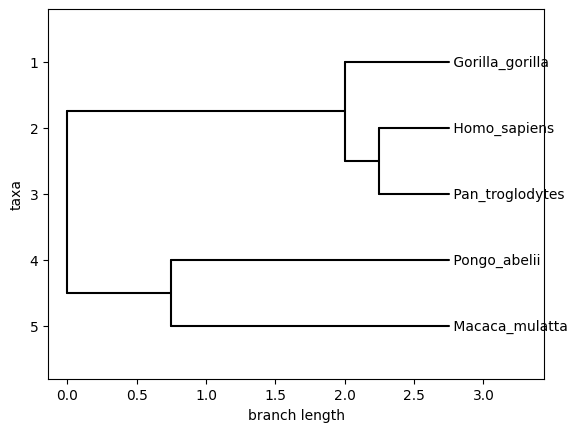

In [2]:
newick = "((Gorilla_gorilla:0.75,(Homo_sapiens:0.5,Pan_troglodytes:0.5):0.25):2.0,(Pongo_abelii:2.0,Macaca_mulatta:2.0):0.75);"
tree = Phylo.read(StringIO(newick), "newick")
Phylo.draw(tree)

Este resultado concuerda bien con la intuición evolutiva: humano y chimpancé aparecen claramente juntos, el gorila se sitúa próximo a este grupo, y, en paralelo, orangután y macaco se agrupan formando el otro gran clado según las distancias del alineamiento.

## Ejercicio 3.2 – Construcción de árboles filogenéticos con distintos métodos

En este apartado se construyen árboles filogenéticos a partir de un mismo alineamiento utilizando criterios diferentes: máxima parsimonia y métodos basados en distancia. El objetivo no es solo obtener árboles, sino comparar cómo cambia la topología según el enfoque empleado y reflexionar sobre las suposiciones implícitas de cada método.

### 1. Carga del archivo FASTA alineado

Todos los métodos filogenéticos parten de un alineamiento múltiple, ya que las comparaciones se realizan posición a posición. En este caso, el archivo FASTA proporcionado ya contiene secuencias alineadas, por lo que puede cargarse directamente.

In [4]:
alignment = AlignIO.read("primates.fasta", "fasta")
print(alignment)
print("Número de secuencias:", len(alignment))
print("Longitud del alineamiento:", alignment.get_alignment_length())

Alignment with 5 rows and 23 columns
ATGCTAGCTAGCTACG--TACG- Homo_sapiens
ATGCTAGCTAGCTACG--TACGA Pan_troglodytes
ATGCTAGCTAG-TACG--TACGA Gorilla_gorilla
ATG-TAGCTAG-TACGCTTACGA Pongo_abelii
ATGATAG-TAG-TATGCTTATGA Macaca_mulatta
Número de secuencias: 5
Longitud del alineamiento: 23


Con este paso, se puede comprobar rápidamente que todas las secuencias tienen la misma longitud y el alineamiento es válido para análisis filogenético.

### 2. Árbol por el método de máxima parsimonia

La máxima parsimonia busca el árbol que minimiza el número total de cambios evolutivos necesarios para explicar el alineamiento. Es un enfoque conceptualmente muy intuitivo: se asume que la evolución tiende a seguir el camino “más simple”, con el menor número de sustituciones posible.

Biopython implementa parsimonia mediante el algoritmo de Fitch, a partir de un árbol inicial.

Primero, se genera un árbol guía inicial (por ejemplo, con UPGMA) para partir de una topología razonable:

In [6]:
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

constructor = DistanceTreeConstructor()
starting_tree = constructor.upgma(dm)

Después, se aplica máxima parsimonia:

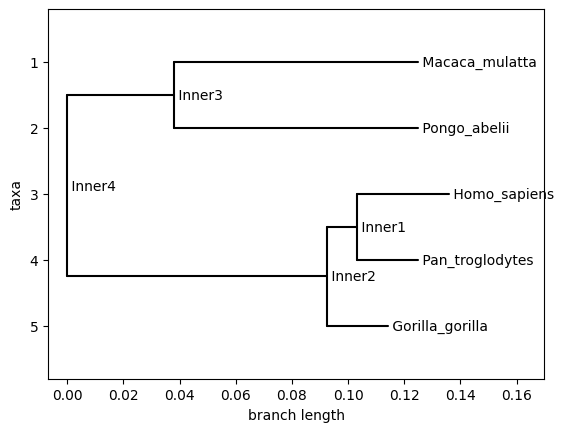

In [9]:
scorer = ParsimonyScorer()
searcher = NNITreeSearcher(scorer)
parsimony_constructor = ParsimonyTreeConstructor(searcher, starting_tree)

tree_parsimony = parsimony_constructor.build_tree(alignment)

Phylo.draw(tree_parsimony)

El árbol obtenido por máxima parsimonia refleja la topología que minimiza el número de cambios a lo largo del alineamiento. Este enfoque es especialmente útil para conjuntos de secuencias relativamente cortas, como este, donde puede interpretarse fácilmente el efecto de cada posición informativa.

### 3. Árboles por métodos de distancia

Para este ejercicio se ha utilizado la distancia *identity*, que se basa en la proporción de posiciones idénticas entre secuencias. Aunque es un modelo simple, resulta adecuado para ilustrar el funcionamiento de los métodos de distancia sin introducir correcciones evolutivas más complejas.

In [10]:
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

#### Árbol por UPGMA

Se usa UPGMA porque es un método jerárquico sencillo que asume un reloj molecular, es decir, tasas de evolución constantes en todos los linajes. Aunque esta suposición no siempre se cumple, UPGMA resulta útil como referencia y es fácil de interpretar.

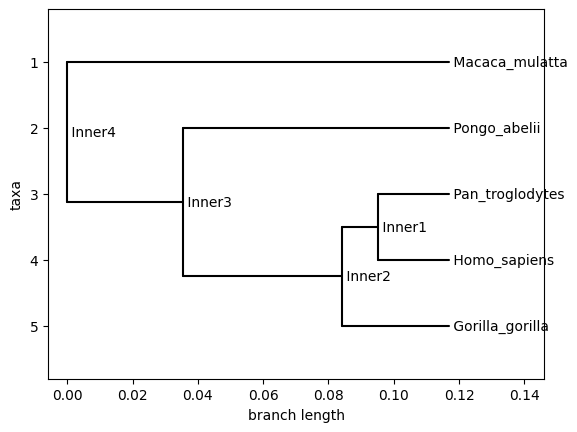

In [11]:
constructor = DistanceTreeConstructor()
tree_upgma = constructor.upgma(dm)

Phylo.draw(tree_upgma)

#### Árbol por Neighbor Joining

A diferencia de UPGMA, Neighbor Joining no asume reloj molecular, lo que suele producir árboles más realistas cuando las tasas evolutivas varían entre linajes. Comparar ambos métodos sobre el mismo alineamiento resulta especialmente interesante.

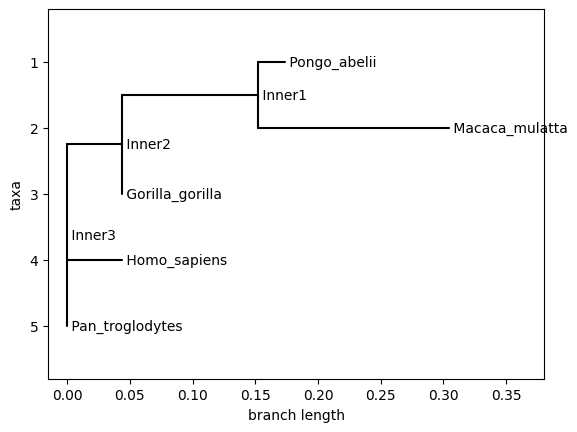

In [12]:
tree_nj = constructor.nj(dm)

Phylo.draw(tree_nj)

### 4. Comparación de los métodos

A partir del mismo alineamiento, los distintos métodos producen árboles que comparten patrones generales, pero también presentan diferencias en su topología. Mientras que UPGMA impone una estructura ultramétrica, Neighbor Joining permite mayor flexibilidad en las longitudes de rama. Por su parte, la máxima parsimonia prioriza la explicación más simple en términos de cambios evolutivos, sin basarse directamente en una matriz de distancias.

### 5. Conclusión

Este ejercicio pone de manifiesto que no existe un único árbol “correcto”, sino diferentes hipótesis filogenéticas que dependen del criterio utilizado para construirlo. La comparación entre máxima parsimonia y métodos de distancia permite entender mejor las suposiciones y limitaciones de cada enfoque, y resalta la importancia de elegir el método adecuado según el tipo de datos y el objetivo del análisis.

## 3.3. Guardado en Newick y graficado

Una vez construidos los árboles filogenéticos mediante los distintos métodos, se han guardado en formato Newick, que constituye el estándar para el intercambio y almacenamiento de árboles filogenéticos. Este paso permite conservar los resultados obtenidos y facilita su reutilización en análisis posteriores.

In [13]:
Phylo.write(tree_parsimony, "tree_parsimony.nwk", "newick")
Phylo.write(tree_upgma, "tree_upgma.nwk", "newick")
Phylo.write(tree_nj, "tree_nj.nwk", "newick")

1

Ahora, a modo buena práctica, los leemos de nuevo para asegurarnos de que se han guardado bien:

In [15]:
tree_parsimony_saved = Phylo.read("tree_parsimony.nwk", "newick")
tree_upgma_saved = Phylo.read("tree_upgma.nwk", "newick")
tree_nj_saved = Phylo.read("tree_nj.nwk", "newick")

A continuación, se representan gráficamente todos los árboles generados, lo que permite compararlos visualmente y apreciar las similitudes y diferencias derivadas del método empleado.

Árbol por Máxima Parsimonia


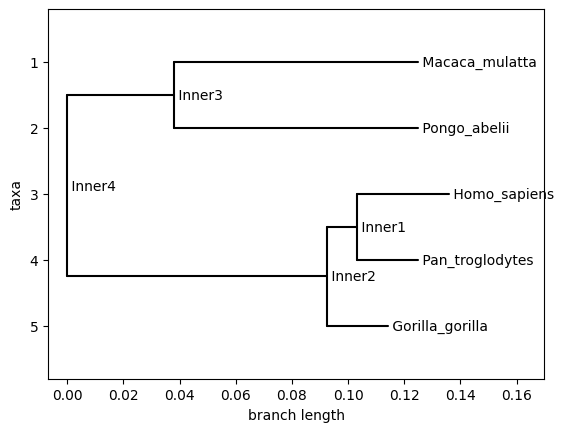

Árbol por UPGMA


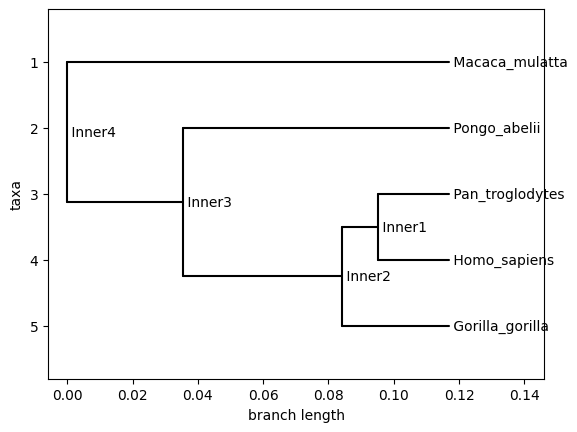

Árbol por Neighbor Joining


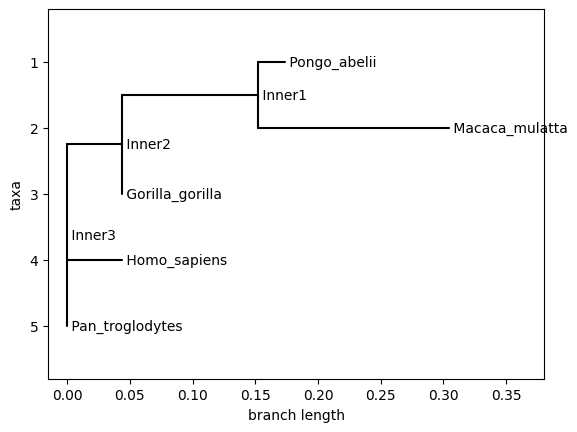

In [16]:
print("Árbol por Máxima Parsimonia")
Phylo.draw(tree_parsimony_saved)

print("Árbol por UPGMA")
Phylo.draw(tree_upgma_saved)

print("Árbol por Neighbor Joining")
Phylo.draw(tree_nj_saved)

## 3.4. Comparación de los árboles obtenidos y conclusiones

### Comparación general de los resultados

A partir del mismo alineamiento de secuencias, los distintos métodos empleados (máxima parsimonia, UPGMA y Neighbor Joining) generan árboles que comparten patrones generales, pero también presentan diferencias en su topología y en la interpretación de las distancias evolutivas. Esta comparación pone de manifiesto que la filogenia no es un resultado único, sino un conjunto de hipótesis que dependen del criterio utilizado para construir el árbol.

En todos los casos se observa un agrupamiento estrecho entre Homo sapiens y Pan troglodytes, lo cual es coherente con su elevada similitud en el alineamiento. Asimismo, Gorilla gorilla aparece próximo a este clado, reforzando la idea de una relación cercana entre estos tres linajes. Este patrón común sugiere que la señal evolutiva dominante del conjunto de datos es suficientemente fuerte como para ser detectada por métodos muy distintos entre sí.

### Comparación entre UPGMA a mano y UPGMA computacional

El árbol obtenido mediante UPGMA a mano en el apartado 3.1 presenta una topología muy similar a la generada computacionalmente a partir de la matriz de distancias. Esta coincidencia resulta especialmente interesante, ya que valida el procedimiento manual y ayuda a comprender de forma intuitiva cómo el algoritmo agrupa progresivamente las secuencias en función de las distancias promedio.

Las pequeñas diferencias observadas en las longitudes de rama se deben a la forma en que Biopython calcula y representa las distancias, pero no afectan a la estructura jerárquica del árbol. Esta comparación refuerza la utilidad del ejercicio manual como herramienta didáctica para entender el funcionamiento interno de UPGMA.

### Parsimonia frente a métodos basados en distancia

El árbol obtenido por máxima parsimonia se construye a partir de un criterio distinto al de los métodos de distancia, ya que busca minimizar el número total de cambios evolutivos en lugar de optimizar distancias promedio entre secuencias. Aun así, la topología general es compatible con la observada en los árboles de UPGMA y Neighbor Joining, lo que indica que el alineamiento contiene una señal filogenética clara.

No obstante, la parsimonia puede ser más sensible a posiciones individuales del alineamiento y a la presencia de homoplasias, especialmente en conjuntos de datos pequeños como este. Por ello, resulta interesante contrastar sus resultados con los obtenidos mediante métodos de distancia, que integran la información del alineamiento de forma más global.

### Diferencias entre UPGMA y Neighbor Joining

La comparación entre UPGMA y Neighbor Joining pone de relieve el impacto de las suposiciones del modelo. UPGMA asume un reloj molecular, lo que da lugar a árboles ultramétricos donde todas las hojas están a la misma distancia de la raíz. Neighbor Joining, en cambio, no impone esta restricción, permitiendo longitudes de rama más flexibles y, en muchos casos, más realistas.

En este conjunto de datos, ambos métodos producen árboles similares en cuanto a agrupamientos principales, pero con diferencias en la distribución de las longitudes de rama. Esto sugiere que, aunque la señal filogenética básica es robusta, la elección del método influye en la interpretación cuantitativa de las distancias evolutivas.

### Conclusión final

La comparación de los árboles obtenidos demuestra que distintos métodos filogenéticos pueden conducir a representaciones ligeramente diferentes de las relaciones evolutivas, incluso cuando parten del mismo alineamiento. Sin embargo, la coincidencia en los agrupamientos principales indica que los datos contienen una señal evolutiva consistente.

Este ejercicio pone de manifiesto la importancia de utilizar y comparar varios métodos al abordar un análisis filogenético, así como de interpretar los resultados a la luz de las suposiciones y limitaciones de cada enfoque. Más allá de la construcción de árboles, el análisis crítico de sus diferencias resulta clave para comprender la naturaleza hipotética de la filogenia y para extraer conclusiones biológicamente razonables.